# Synthetic worm image generator

This notebook should result in the creation of a set of realistic but synthetic images (and ground-truth masks) of c. elegans worms.

### Imports

In [1]:
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from copy import copy

## Pseudocode

load image

choose a mask

worm = pixels corresponding to this mask from originial image

apply transform to worm

apply transform to mask

insert transformed worm into original image

save image
save mask

### Functions


In [2]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 4)).astype(np.uint8)[:,:,:3]

# Main body


## Define data

In [3]:
# NUM_IMAGES = 5
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/cropped_data/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/cropped_collated_dataset/original_cropped_data/'
PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data_pre_exams/eval/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/cropped_collated_dataset/CX11271_worms10_food1-10_Set1_Pos4_Ch4_19052017_113042/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/cropped_collated_dataset/NIC199_worms10_food1-10_Set7_Pos4_Ch4_19052017_153012/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/BBBC/BBBC_CURATED'



FNAMES = [f for f in os.listdir(PATH_TO_TEST_IMAGES_DIR) if not f.startswith('.')]
FNAMES = sorted(FNAMES) #, key=int)

test_fname = FNAMES[0]

# print(list(np.random.choice(len(FNAMES), size=3, replace=False)))
# TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(i,i)) for i in FNAMES] # np.random.choice(len(FNAMES), size=NUM_IMAGES, replace=False)]

TEST_IMAGE_PATH = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(test_fname,test_fname))

MASKS_DIR = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/masks/'.format(test_fname))
MASK_FNAMES = [f for f in os.listdir(MASKS_DIR) if not f.startswith('.')]


# Size, in inches, of the output images.
IMAGE_SIZE = (30,30)

## Load and show initial image

In [4]:
image = Image.open(TEST_IMAGE_PATH)
image_np = load_image_into_numpy_array(image)

masks = []
for m in MASK_FNAMES:
    mask = Image.open(os.path.join(MASKS_DIR,m))
    masks.append(np.asarray(mask)[:,:,:3])
    
masks_array = np.asarray(masks)

mask_sum = np.sum(masks_array, axis=3)
mask_sum = np.sum(mask_sum, axis=0)

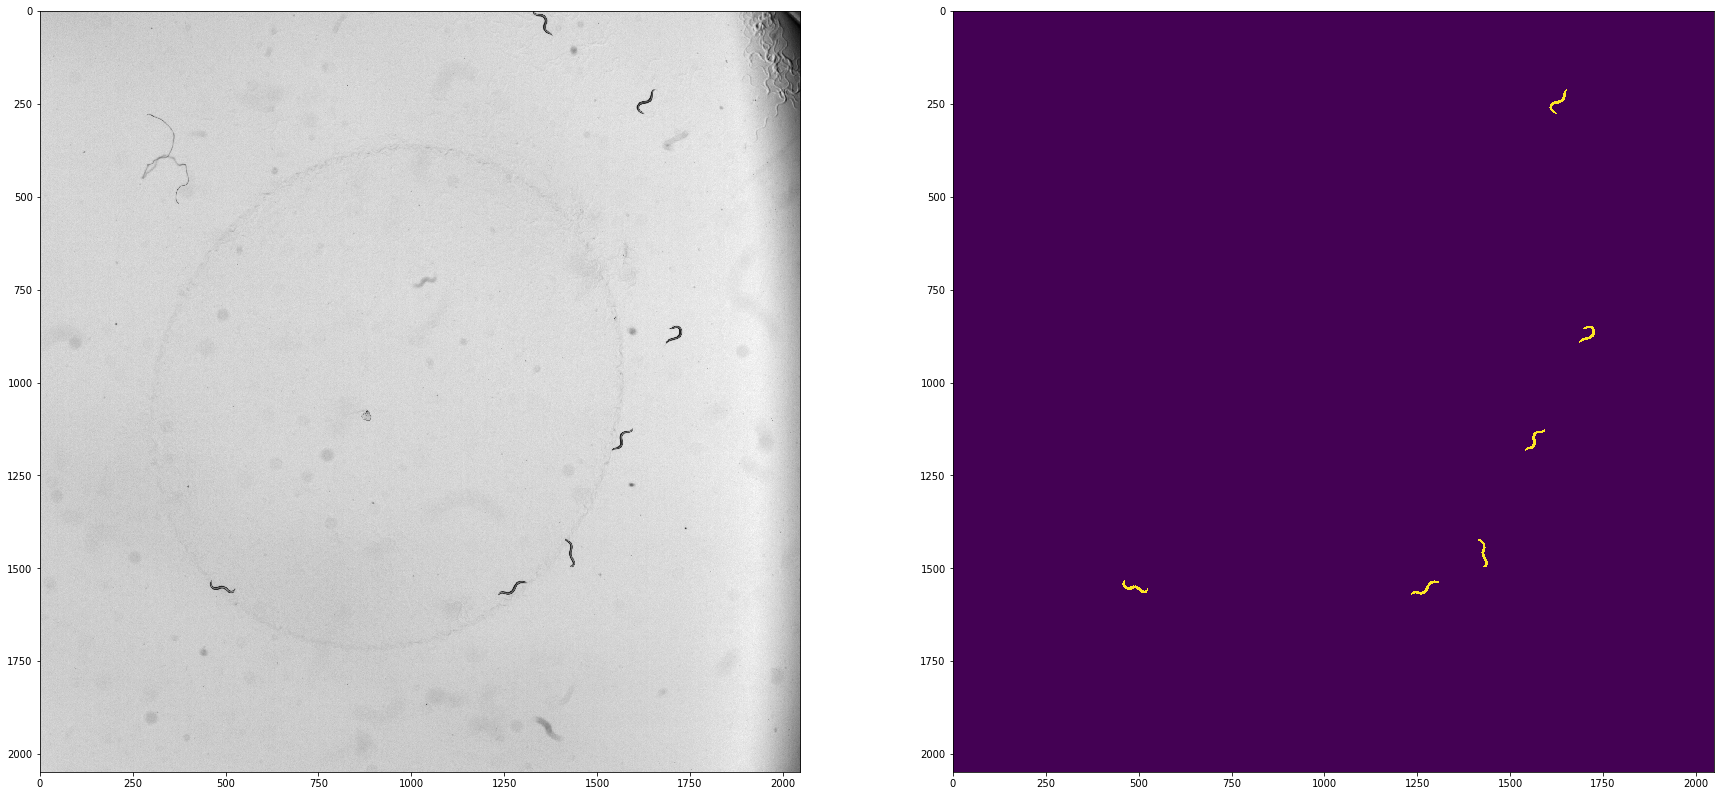

In [5]:
plt.figure(figsize=IMAGE_SIZE)

plt.subplot(1,2,1)
plt.imshow(image_np)

plt.subplot(1,2,2)
plt.imshow(mask_sum)
plt.show()
plt.close()

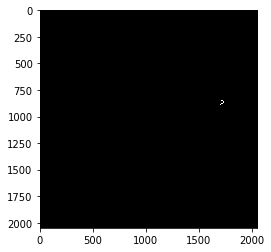

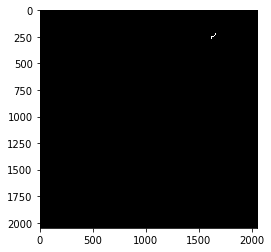

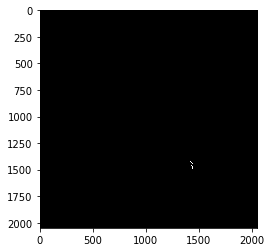

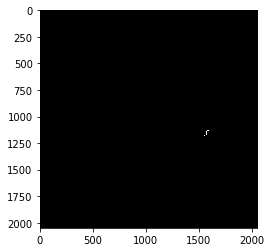

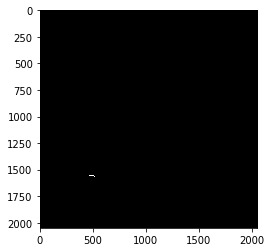

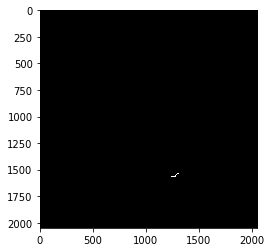

In [6]:
plt.figure()
for m in masks:
    plt.imshow(m)
    plt.show()
plt.close()

Worms have a typical length of ~50 pixels. We will consider worms existing within a radius of this size of another worm as close

In [59]:
worm_mask = masks[4]
worm_where = np.where(worm_mask)
worm_shifted = np.where(worm_mask)

shifts = [10,0,0]

for i,j in zip(worm_shifted,shifts):
    i += j

new_image = copy(image_np)
new_image[worm_shifted] = image_np[worm_where]

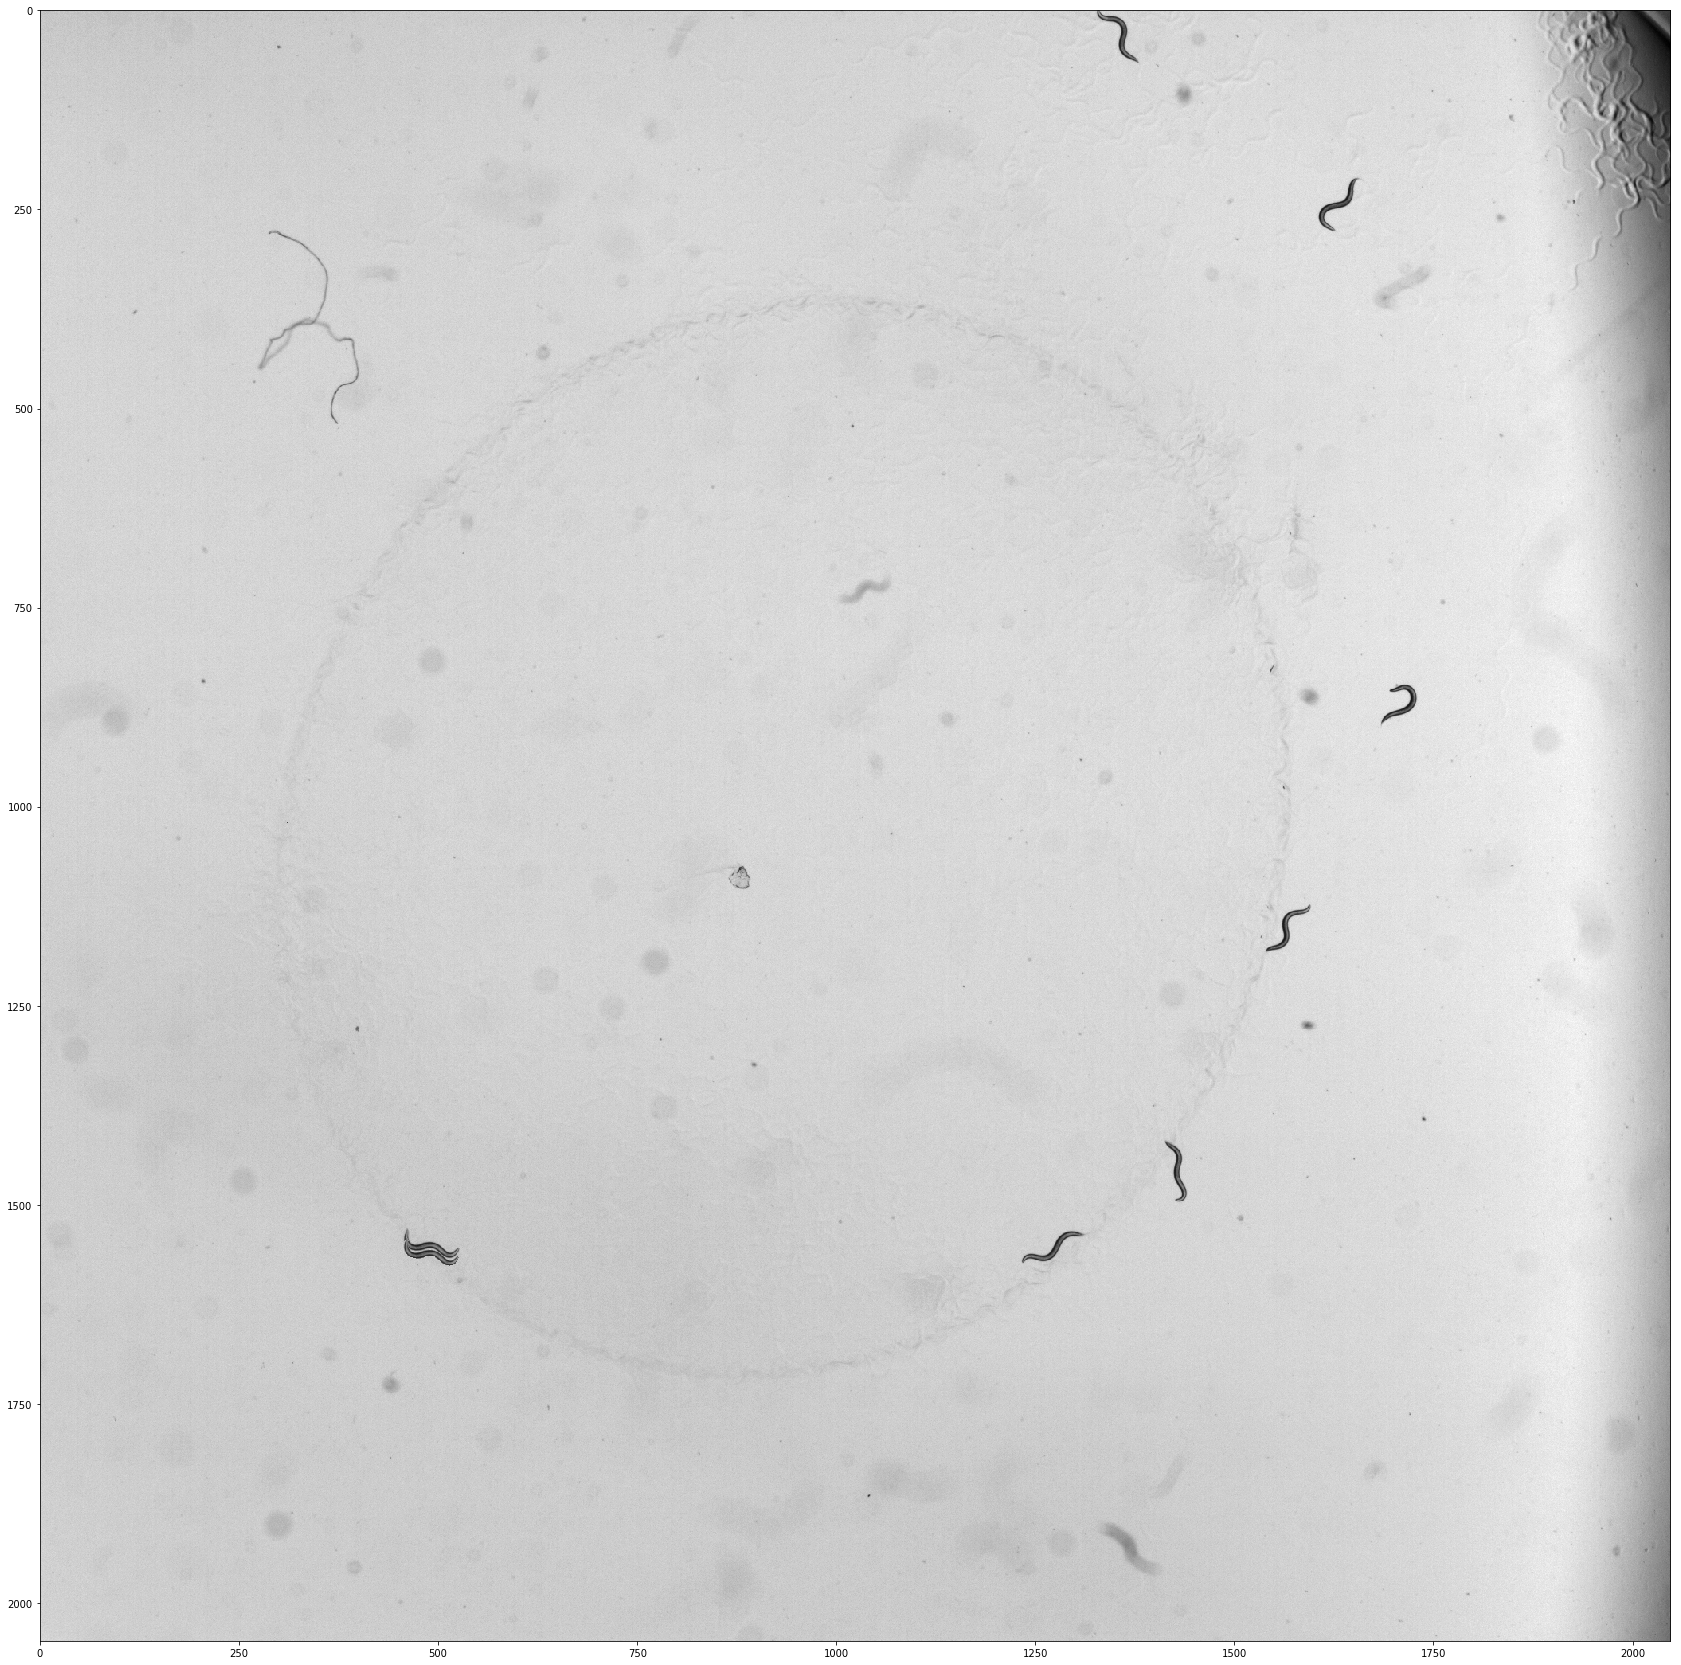

In [60]:
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(new_image)
plt.show()